<a href="https://colab.research.google.com/github/RJ-Stony/Item-based-CF-dot-production/blob/main/Item_based_%ED%98%91%EC%97%85%ED%95%84%ED%84%B0%EB%A7%81_Dot_Production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 필요한 라이브러리 Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, mean_squared_error
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터 로드 및 확인

In [ ]:
path = "/content/drive/MyDrive/코딩 & 알고리즘 준비/빅데이터 알고리즘/기말 프로젝트/Data/Movielens/"
os.listdir(path)

movies_file = os.path.join(path, "movies_refined.csv")
ratings_file = os.path.join(path, "ratings_refined.csv")

movies_df = pd.read_csv(movies_file)
ratings_df = pd.read_csv(ratings_file)

movies_info = movies_df.info()
ratings_info = ratings_df.info()

movies_head = movies_df.head()
ratings_head = ratings_df.head()

movies_info, ratings_info, movies_head, ratings_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9703 entries, 0 to 9702
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9703 non-null   int64 
 1   title    9703 non-null   object
 2   year     9703 non-null   int64 
 3   genres   9703 non-null   object
dtypes: int64(2), object(2)
memory usage: 303.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100789 entries, 0 to 100788
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100789 non-null  int64  
 1   movieId    100789 non-null  int64  
 2   rating     100789 non-null  float64
 3   timestamp  100789 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


(None,
 None,
    movieId                        title  year  \
 0        1                    Toy Story  1995   
 1        2                      Jumanji  1995   
 2        3             Grumpier Old Men  1995   
 3        4            Waiting to Exhale  1995   
 4        5  Father of the Bride Part II  1995   
 
                                         genres  
 0  Adventure Animation Children Comedy Fantasy  
 1                   Adventure Children Fantasy  
 2                               Comedy Romance  
 3                         Comedy Drama Romance  
 4                                       Comedy  ,
    userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  964983815
 4       1       50     5.0  964982931)

# 데이터 전처리

## Null 값 처리

In [ ]:
# Movies 데이터 Null 값 처리
print("Movies 데이터 결측값:\n", movies_df.isnull().sum())
movies_df['title'] = movies_df['title'].fillna('Unknown')

# Ratings 데이터 Null 값 처리
print("Ratings 데이터 결측값:\n", ratings_df.isnull().sum())
ratings_df = ratings_df.dropna()

Movies 데이터 결측값:
 movieId    0
title      0
year       0
genres     0
dtype: int64
Ratings 데이터 결측값:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


## 데이터 타입 변환

In [ ]:
# 영화 연도가 숫자가 아닌 경우 처리
if movies_df['year'].dtype != 'int64':
    movies_df['year'] = pd.to_numeric(movies_df['year'], errors='coerce').fillna(0).astype(int)

# 평점 데이터가 이상한 값(예: 0보다 작거나 5보다 큰 값)이 있는지 확인
print("Ratings 데이터 이상 값 확인:", ratings_df[(ratings_df['rating'] < 0) | (ratings_df['rating'] > 5)])
ratings_df = ratings_df[(ratings_df['rating'] >= 0) & (ratings_df['rating'] <= 5)]

Ratings 데이터 이상 값 확인: Empty DataFrame
Columns: [userId, movieId, rating, timestamp]
Index: []


## 시간 가중치 기반 평점 반영

In [ ]:
# 시간 가중치를 반영한 평점 계산

current_time = datetime.now().timestamp()
max_time_diff = ratings_df['timestamp'].max() - ratings_df['timestamp'].min()
ratings_df['time_weight'] = (current_time - ratings_df['timestamp']) / max_time_diff
ratings_df['weighted_rating'] = ratings_df['rating'] * (1 - ratings_df['time_weight'])

## 데이터 통합

In [ ]:
# Movies와 Ratings 데이터 병합
merged_df = pd.merge(ratings_df, movies_df, on='movieId', how='inner')

# 중복 데이터 제거
merged_df.drop_duplicates(inplace=True)

print("병합된 데이터 샘플:\n", merged_df.head())

print("\n[전처리 완료]\n")
print(f"영화 데이터: {len(movies_df)}개 영화 로드 완료")
print(f"평점 데이터: {len(ratings_df)}개 평점 로드 완료")
print(f"평균 평점: {ratings_df['rating'].mean():.2f}, 시간 가중치를 적용한 평균 평점: {ratings_df['weighted_rating'].mean():.2f}")

병합된 데이터 샘플:
    userId  movieId  rating  timestamp  time_weight  weighted_rating  \
0       1        1     4.0  964982703     1.083384        -0.333535   
1       1        3     4.0  964981247     1.083386        -0.333544   
2       1        6     4.0  964982224     1.083385        -0.333538   
3       1       47     5.0  964983815     1.083382        -0.416911   
4       1       50     5.0  964982931     1.083384        -0.416918   

                  title  year                                       genres  
0             Toy Story  1995  Adventure Animation Children Comedy Fantasy  
1      Grumpier Old Men  1995                               Comedy Romance  
2                  Heat  1995                        Action Crime Thriller  
3  Seven (a.k.a. Se7en)  1995                             Mystery Thriller  
4   Usual Suspects, The  1995                       Crime Mystery Thriller  

[전처리 완료]

영화 데이터: 9703개 영화 로드 완료
평점 데이터: 100789개 평점 로드 완료
평균 평점: 3.50, 시간 가중치를 적용한 평균 평점: 0.89


# 데이터 정규화 및 스케일링

## 평점 정규화

In [ ]:
# 평점 정규화 (0~1 스케일)
ratings_df['rating_normalized'] = (ratings_df['rating'] - ratings_df['rating'].min()) / (ratings_df['rating'].max() - ratings_df['rating'].min())

## 장르 데이터 벡터화

In [ ]:
# 장르를 리스트로 변환
movies_df['genres'] = movies_df['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else [])

# 장르 데이터 원-핫 인코딩
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(movies_df['genres'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

# 영화 ID와 결합
movies_with_genres = pd.concat([movies_df[['movieId']], genre_df], axis=1)
print("장르 벡터화 샘플:\n", movies_with_genres.head())

장르 벡터화 샘플:
    movieId  Action  Action Adventure  Action Adventure Animation  \
0        1       0                 0                           0   
1        2       0                 0                           0   
2        3       0                 0                           0   
3        4       0                 0                           0   
4        5       0                 0                           0   

   Action Adventure Animation Children  \
0                                    0   
1                                    0   
2                                    0   
3                                    0   
4                                    0   

   Action Adventure Animation Children Comedy  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   Action Adventure Animation C

# 이상 데이터 탐지

## 유저별 최소 평가 수 확인

In [ ]:
# 최소 평점 수를 기준으로 필터링 (예: 10개 이하 평점을 남긴 유저 제거)
user_ratings_count = ratings_df.groupby('userId').size()
active_users = user_ratings_count[user_ratings_count > 10].index
ratings_df = ratings_df[ratings_df['userId'].isin(active_users)]
print("평점이 충분한 유저 수:", len(active_users))

평점이 충분한 유저 수: 610


## 영화별 최소 평가 수 확인

In [ ]:
# 최소 평점 수를 기준으로 필터링 (예: 5개 이하 평점을 받은 영화 제거)
movie_ratings_count = ratings_df.groupby('movieId').size()
popular_movies = movie_ratings_count[movie_ratings_count > 5].index
ratings_df = ratings_df[ratings_df['movieId'].isin(popular_movies)]
print("평가가 충분한 영화 수:", len(popular_movies))

평가가 충분한 영화 수: 3267


# user-item 평점 행렬 생성

In [ ]:
# 유저-영화 평점 행렬 생성
user_movie_matrix = ratings_df.pivot_table(index='userId', columns='movieId', values='rating_normalized').fillna(0)

print("유저-아이템 평점 행렬 샘플:")
print(user_movie_matrix.head())

유저-아이템 평점 행렬 샘플:
movieId    1       2         3       4       5         6       7       8       \
userId                                                                          
1        0.777778     0.0  0.777778     0.0     0.0  0.777778     0.0     0.0   
2        0.000000     0.0  0.000000     0.0     0.0  0.000000     0.0     0.0   
3        0.000000     0.0  0.000000     0.0     0.0  0.000000     0.0     0.0   
4        0.000000     0.0  0.000000     0.0     0.0  0.000000     0.0     0.0   
5        0.777778     0.0  0.000000     0.0     0.0  0.000000     0.0     0.0   

movieId  9       10      ...  174055  175303  176101  176371  177593  177765  \
userId                   ...                                                   
1           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
2           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0

# 아이템 유사도 행렬 계산

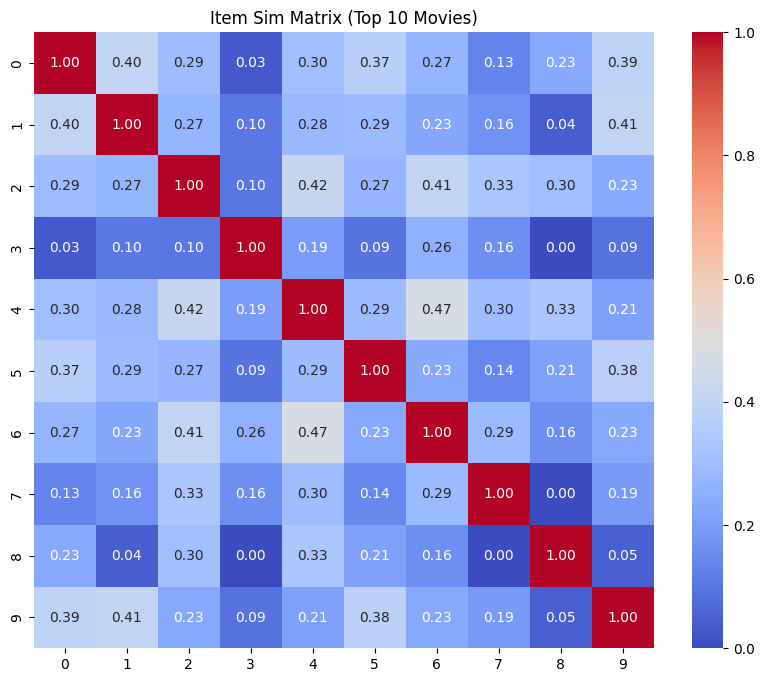

In [ ]:
# 아이템 기반 유사도 행렬 계산
item_similarity_matrix = cosine_similarity(user_movie_matrix.T)

# 데이터프레임으로 변환
item_similarity_df = pd.DataFrame(item_similarity_matrix,
                                   index=user_movie_matrix.columns,
                                   columns=user_movie_matrix.columns)

# 유사도 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(item_similarity_matrix[:10, :10], annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Item Sim Matrix (Top 10 Movies)")
plt.show()

## Pearson 유사도 계산

In [ ]:
# Pearson Correlation 유사도는 사용자 간 상관관계를 기반
pearson_similarity_matrix = user_movie_matrix.T.corr().fillna(0)

# Pearson 유사도 데이터프레임 생성
pearson_similarity_df = pd.DataFrame(pearson_similarity_matrix,
                                     index=user_movie_matrix.columns,
                                     columns=user_movie_matrix.columns).fillna(0)

print("Pearson 유사도 행렬 샘플:")
print(pearson_similarity_df.head())

Pearson 유사도 행렬 샘플:
movieId    1         2         3         4         5         6         7       \
movieId                                                                         
1        1.000000  0.006092  0.085877  0.154504  0.105973  0.071845  0.119955   
2        0.006092  1.000000 -0.004262 -0.018223  0.005726  0.003738  0.008301   
3        0.085877 -0.004262  1.000000 -0.010974 -0.005310 -0.013652 -0.009306   
4        0.154504 -0.018223 -0.010974  1.000000  0.111336  0.034775  0.079545   
5        0.105973  0.005726 -0.005310  0.111336  1.000000  0.296787  0.087925   

movieId    8         9         10      ...  174055  175303  176101  176371  \
movieId                                ...                                   
1        0.112397  0.052734 -0.031988  ...     0.0     0.0     0.0     0.0   
2        0.017589 -0.008332  0.057081  ...     0.0     0.0     0.0     0.0   
3       -0.005489 -0.004435 -0.008557  ...     0.0     0.0     0.0     0.0   
4        0.036329 -0.00

## 혼합 유사도 계산

In [ ]:
# 공통된 영화 ID 추출
common_movie_ids = list(set(user_movie_matrix.columns) & set(movies_with_genres['movieId']))

# 평점 기반 유사도 재정렬
item_similarity_matrix = pd.DataFrame(item_similarity_matrix,
                                      index=user_movie_matrix.columns,
                                      columns=user_movie_matrix.columns)
item_similarity_matrix = item_similarity_matrix.loc[common_movie_ids, common_movie_ids]

# 장르 기반 유사도 재정렬
genre_df_filtered = genre_df.loc[movies_with_genres['movieId'].isin(common_movie_ids)]
genre_similarity_matrix = cosine_similarity(genre_df_filtered.values)
genre_similarity_matrix = pd.DataFrame(genre_similarity_matrix,
                                        index=common_movie_ids,
                                        columns=common_movie_ids)

# 혼합 유사도 계산
alpha = 0.7
beta = 0.3
hybrid_similarity_matrix = alpha * item_similarity_matrix.values + beta * genre_similarity_matrix.values

print("혼합 유사도 행렬 샘플:")
print(hybrid_similarity_matrix[:5, :5])

혼합 유사도 행렬 샘플:
[[1.         0.2822908  0.20534908 0.02222361 0.21317489]
 [0.2822908  1.         0.18986972 0.07148951 0.19846046]
 [0.20534908 0.18986972 1.         0.06932644 0.29463024]
 [0.02222361 0.07148951 0.06932644 1.         0.13410903]
 [0.21317489 0.19846046 0.29463024 0.13410903 1.        ]]


# Dot Product 기반 평점 예측

In [ ]:
# 평점 예측 함수
def predict_ratings(user_movie_matrix, similarity_matrix):
    def parallel_dot_product(user_row):
        numerator = np.dot(user_row, similarity_matrix)
        denominator = np.abs(similarity_matrix).sum(axis=1)
        return numerator / denominator

    predicted_ratings = Parallel(n_jobs=-1)(
        delayed(parallel_dot_product)(user_row) for user_row in user_movie_matrix.values
    )
    return pd.DataFrame(predicted_ratings, index=user_movie_matrix.index, columns=user_movie_matrix.columns)

predicted_ratings_df = predict_ratings(user_movie_matrix, item_similarity_matrix)

print("예측된 평점 행렬 샘플:")
print(predicted_ratings_df.head())

예측된 평점 행렬 샘플:
movieId    1         2         3         4         5         6         7       \
userId                                                                          
1        0.064385  0.059406  0.065198  0.059638  0.061179  0.063713  0.065290   
2        0.006779  0.007054  0.004605  0.001447  0.005474  0.006913  0.004540   
3        0.002453  0.001907  0.002228  0.002712  0.002284  0.002654  0.002409   
4        0.042400  0.040480  0.048304  0.063885  0.047849  0.042259  0.051950   
5        0.012508  0.013294  0.013411  0.038560  0.017725  0.012399  0.017718   

movieId    8         9         10      ...    174055    175303    176101  \
userId                                 ...                                 
1        0.058405  0.080504  0.063726  ...  0.052764  0.050657  0.050838   
2        0.006121  0.002492  0.006523  ...  0.008739  0.013060  0.009642   
3        0.001377  0.003157  0.002458  ...  0.001588  0.001234  0.001338   
4        0.045760  0.067246  0.042872 

# 평가 지표 계산

In [ ]:
# 평가 함수
def evaluate_predictions(actual, predicted):
    actual_flat = actual.values.flatten()
    predicted_flat = predicted.values.flatten()
    mask = ~np.isnan(actual_flat)
    actual_flat = actual_flat[mask]
    predicted_flat = predicted_flat[mask]
    mae = mean_absolute_error(actual_flat, predicted_flat)
    mse = mean_squared_error(actual_flat, predicted_flat)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

## 평가 지표 다양화

In [ ]:
# Precision, Recall, Coverage 계산
def precision_recall_at_k(actual, predicted, k=10):
    total_precision, total_recall = 0, 0
    for user in actual.index:
        actual_movies = actual.loc[user].dropna().index
        predicted_movies = predicted.loc[user].nlargest(k).index
        true_positives = len(set(actual_movies) & set(predicted_movies))
        total_precision += true_positives / k
        total_recall += true_positives / len(actual_movies) if len(actual_movies) > 0 else 0
    return total_precision / len(actual), total_recall / len(actual)

# Coverage 계산
precision, recall = precision_recall_at_k(user_movie_matrix, predicted_ratings_df)
coverage = len(predicted_ratings_df.columns) / len(movies_df)

# 평가 결과 정리
mae, mse, rmse = evaluate_predictions(user_movie_matrix, predicted_ratings_df)
results = pd.DataFrame({"Metric": ["MAE", "MSE", "RMSE", "Precision@10", "Recall@10", "Coverage"],
                        "Value": [mae, mse, rmse, precision, recall, coverage]})

print(results)

         Metric     Value
0           MAE  0.051553
1           MSE  0.019853
2          RMSE  0.140899
3  Precision@10  1.000000
4     Recall@10  0.003061
5      Coverage  0.336700


# 사용자별 추천 리스트 생성

In [ ]:
# title 추가
movies_with_genres = pd.merge(movies_with_genres, movies_df[['movieId', 'title']], on='movieId', how='left')

# 장르를 고려한 추천
def diversified_recommendations(predictions, user_id, movies_with_genres, n_recommendations=10):
    user_predictions = predictions.loc[user_id].sort_values(ascending=False)
    top_movie_ids = user_predictions.index

    diversified_recs = []
    for genre in genre_df.columns:
        genre_movies = movies_with_genres[(movies_with_genres['movieId'].isin(top_movie_ids)) & (movies_with_genres[genre] == 1)]
        if not genre_movies.empty:
            diversified_recs.extend(genre_movies.head(1)['title'].values)
            if len(diversified_recs) >= n_recommendations:
                break

    return diversified_recs

# 추천 리스트 정리 함수
def print_recommendations(recommendations):
    print("\n[추천 영화 리스트]")
    print(pd.DataFrame({"Rank": range(1, len(recommendations) + 1), "Movie Title": recommendations}))

# 특정 유저에 대한 추천
diverse_recommendations = diversified_recommendations(predicted_ratings_df, user_id=1, movies_with_genres=movies_with_genres)
print_recommendations(diverse_recommendations)


[추천 영화 리스트]
   Rank                          Movie Title
0     1                         Sudden Death
1     2                           Quest, The
2     3           How to Train Your Dragon 2
3     4                                Brave
4     5                     Incredibles, The
5     6  TMNT (Teenage Mutant Ninja Turtles)
6     7          Madagascar: Escape 2 Africa
7     8       Ice Age: Dawn of the Dinosaurs
8     9                       Chicken Little
9    10                                Rango


## 특정 장르 기반 추천

In [ ]:
def genre_based_recommendations(predictions, user_id, movies_with_genres, genre_filter, n_recommendations=10):
    user_predictions = predictions.loc[user_id].sort_values(ascending=False)
    top_movie_ids = user_predictions.index

    filtered_recs = movies_with_genres[
        (movies_with_genres['movieId'].isin(top_movie_ids)) & (movies_with_genres[genre_filter] == 1)
    ]
    return filtered_recs.head(n_recommendations)['title'].tolist()

# 특정 장르 추천
genre_recommendations = genre_based_recommendations(predicted_ratings_df, user_id=1, movies_with_genres=movies_with_genres, genre_filter="Action")
print("\n[액션 장르 추천 영화 리스트]")
print_recommendations(genre_recommendations)


[액션 장르 추천 영화 리스트]

[추천 영화 리스트]
   Rank                                        Movie Title
0     1                                       Sudden Death
1     2                      Under Siege 2: Dark Territory
2     3  Bloodsport 2 (a.k.a. Bloodsport II: The Next K...
3     4                                         Bloodsport
4     5                                 Kiss of the Dragon
5     6                                   Last Castle, The
6     7                                       Walking Tall
7     8                                       Jason Bourne
